In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import date
from datetime import timedelta

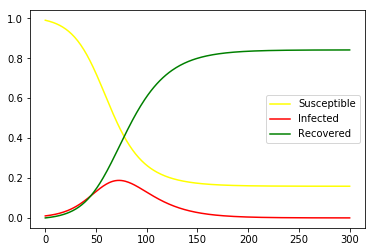

Cumulative number of infected people: 84.1%
Duration before the peak: 73


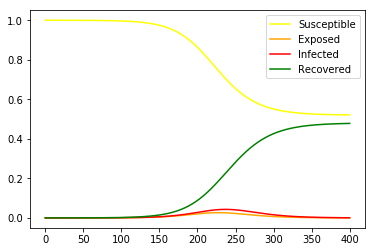

Cumulative number of infected people: 0.47809741537306305
Duration before the peak: 237


In [2]:
run corona_sir_seir.ipynb

In [3]:
def is_metropolis(state, province):
    return province == state or str(province) == 'nan'

def clean_date(datestring):
    datestring = datestring.split('/')
    return date(2020, int(datestring[0]), int(datestring[1]))

In [4]:
with open('covid_19_aggregation.csv') as csv:
    data_csv = pd.read_csv(csv)

data_csv = data_csv[data_csv['ObservationDate'].notna()]
data_csv['ObservationDate'] = data_csv.apply(lambda row: clean_date(row['ObservationDate']), axis=1)
data_csv['Confirmed'] = data_csv.apply(lambda row: int(row['Confirmed']), axis=1)

In [58]:
# Cost function computation 
def J(x, I_ref, regularization_methods=None, T=200):
    
    pe, pi = x[0], x[1]
    
    I0, E0 = I_ref[0], 4*I_ref[0]
    if 'tikhonov' in regularization_methods or 'max' in regularization_methods:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, 6, 10, T)
    else:
        S_list, E_list, I_list, R_list = SEIR(E0, I0, pe, pi, 6, 10, len(I_ref)-1)
    I_list = np.array(I_list)
    err = np.linalg.norm(I_ref-I_list[:len(I_ref)])/np.linalg.norm(I_ref)
    
    reg = 0
    if 'pe' in regularization_methods:
        reg += regularization_methods['pe']*pe
    if 'pi' in regularization_methods:
        reg += regularization_methods['pi']*pi
    if 'max' in regularization_methods:
        reg += regularization_methods['max']*np.max(I_list)
    if 'tikhonov' in regularization_methods:
        reg += regularization_methods['tikhonov']*np.linalg.norm(I_list)
    
    return err + reg

In [59]:
def random_sample_minimize(J, bounds, extra_parameters, n_grid=1000, n_iter=25, local_method='SLSQP'):

    t0 = time()
    

    pe_bounds, pi_bounds = bounds[0], bounds[1]

    pe_choice = np.random.choice(np.linspace(*pe_bounds, n_grid), n_iter)
    pi_choice = np.random.choice(np.linspace(*pi_bounds, n_grid), n_iter)

    best_results = {'fun': float('inf')}
    for i in range(n_iter):

        pe, pi = pe_choice[i], pi_choice[i]
        x0 = np.array([pe, pi])

        new_results = minimize(
            J, 
            x0, 
            extra_parameters, 
            method=local_method,
            bounds=[pe_bounds, pi_bounds]
        )

        if new_results['success'] and new_results['fun'] < best_results['fun']:
            
            best_results = new_results
    
    best_results['runtime'] = time()-t0
    
    return best_results

In [72]:
def analyze_data(I_ref, confinement_date):
    # Extrapolation window
    T = 200

    # Bounds for parameters we need to fit
    pe_bounds = (1E-100, 10)
    pi_bounds = (1E-10, 10)
    exposition_ratio_bounds = (1, 20)

    bounds = [pe_bounds, pi_bounds]

    n_grid = 1000
    n_iter = 50

    # Regularization methods
    regularization_methods = {
            'pe': 1,
            'pi': 1,
            'max': 0,
            'tikhonov': 0
        }

    extra_parameters = (I_ref, regularization_methods, T)

    best_results = random_sample_minimize(J, bounds, extra_parameters, n_grid, n_iter, local_method='SLSQP')

   
    best_pe, best_pi = best_results['x'][0], best_results['x'][1]
    print('best results', best_pe, best_pi)

    #OVERRIDE 
    best_exposition_ratio = 4
    # Fitted model
    S_list, E_list, I_list, R_list = SEIR(4*I_ref[0], I_ref[0], best_pe, best_pi, 6, 10, T)

    # Plot results
    plot_results(I_ref, S_list, E_list, I_list, R_list)

    print("Cumulative number of infected people: {}%".format(round(100*R_list[-1], 1)))
    try:
        peak_value = peak(I_list)
        date_peak = confinement_date + timedelta(peak_value)
        print("Duration before the peak: {}".format(peak_value))
        print("Date of the peak: {}".format(date_peak.strftime("%d/%m/%Y")))
    except: 
        print('No peak in the range of {} days after confinement'.format(T))
    print('=====================================================================')

In [73]:
country_pop = {
    'Italy': 60.36e6,
    'France': 69.99e6,
    'Germany': 83.02e6
}

confinement_date = {
    'Italy': date(2020, 3, 9),
    'France': date(2020, 3, 17),
    'Germany': date(2020, 3, 22),
}

delay_days = 15 #number of days before we can see the impact of the confinement

def analyze_country(country):
    data_country = data_csv[data_csv['Country_Region'] == country]
    data_country = data_country[
        data_country.apply(lambda row: is_metropolis(country, row['Province_State']), axis=1)
        ]
    data_country = data_country.reset_index()

    data_post_conf = data_country[
        data_country.apply(lambda row: 
                           (row['ObservationDate'] - confinement_date[country]).days > delay_days
        , axis=1) 
    ]

    delta = data_post_conf.iloc[-1]['ObservationDate'] - data_post_conf.iloc[0]['ObservationDate']
    if delta.days + 1 != len(np.array(data_post_conf[['ObservationDate']].T)[0]):
        print("ERROR, check if all dates are in the dataset", 
              delta.days + 1, 
              len(np.array(data_post_conf[['ObservationDate']].T)[0])
             )
        return 

    I = data_post_conf[['Confirmed']].T
    I_ravel = [nb / country_pop[country] for nb in np.array(I)[0]]
    print(I_ravel)
    analyze_data(I_ravel, confinement_date[country])

[0.0012323724320742213, 0.0013351391650099403, 0.0014330351225977469, 0.0015320079522862823, 0.0016184393638170975, 0.0016855367793240557, 0.0017526838966202783, 0.0018319085487077534, 0.001909244532803181, 0.001985205434062293, 0.002064811133200795, 0.002136315440689198, 0.0021959410205434063, 0.002246288933068257, 0.002309840954274354, 0.0023794897282968853, 0.002444946984758118, 0.002522713717693837]
best results 0.0 1.000000082740371e-10


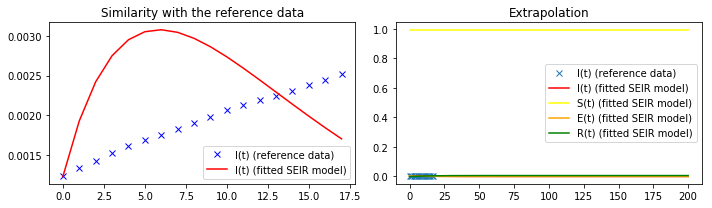

Cumulative number of infected people: 0.6%
Duration before the peak: 6
Date of the peak: 15/03/2020


In [74]:
if __name__ == '__main__':
    country = 'Italy' 
    analyze_country(country)